<a href="https://colab.research.google.com/github/kdmalc/intro-computer-vision/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ELEC/COMP 447/546 Assignment 3


## General instructions
Please copy this colab notebook into your own Drive to edit. This notebook will also serve as your final submission report - please ensure that code cells run correctly, and that all non-code (text/latex) blocks are rendered correctly before submissing the file. Feel free to add any additional cells (code or text) you need. Please follow good coding, markdown, and presentation etiquette.

__Please do not use any AI tools for this assignment.__


## Submission instructions

- Before submitting, please `run-all` the code. This will re-render your entire jupyter file cell by cell to produce all the outputs.

- You are required to download the colab notebook as a `.ipynb` file and submit it to canvas. Please name your `.ipynb` file as `netid.ipynb`

- Modify the text cell on top to include your name and the names of any collaborators from this class you worked with on this assignment.

- Download a pdf of the executed colab notebook. You can use print -> save as pdf. Please name your `.pdf` file as `netid.pdf`.

- Any extra images used in the homework should also be uploaded to canvas.

- For simplicity, you can also upload a `netid.zip` file to canvas containing all solution files.

In [3]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from scipy.signal import convolve2d
import copy

In [ ]:
def min_max_normalize(x): return (x - x.min())/(x.max() - x.min()) # converts 0-255 uint8 image to 0-1 floating point image. Here, the max value of the image is mapped to 1 and min value is mapped to 0.

def normalize_255(x): return x/255.0 # converts a 0-255 uint8 image to a floating 0-1 image by dividing by 255. Here, the images are consistently divided by 255.0 (max achievable value in an 8-bit image)

def show_image(image, title="", dpi=150, axis='off', cmap=None):
    im = image.copy()
    plt.figure(dpi=dpi)
    plt.imshow(im, cmap=cmap)
    plt.axis(axis)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def show_image_subplot(images : list[np.ndarray], num_rows: int, num_cols: int,
                       titles: list[str] = [], axis: str = 'off' , dpi: int = 80,
                       cmap: str | None = None) -> None:
    """ shows a matplotlib subplot for multiple images"""
    assert num_rows > 1 or num_cols > 1 , "Please ensure that you have more than 1 row or col"
    assert len(images) == int(num_rows*num_cols), "Please ensure that number of images provided match rows x cols product"
    titles = titles + ["No Title" for _ in range(len(images)-len(titles))] if len(titles) < len(images) else titles[:len(images)]
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, dpi=dpi)
    axs_flat = axs.flatten()
    for (_ax, _im, _title) in zip(axs_flat, images, titles):
        _ax.imshow(_im, cmap=cmap)
        _ax.axis(axis)
        _ax.set_title(_title)
    plt.tight_layout()
    plt.show()

def gaussian2D(sigma: tuple[float, float], kernel_size: tuple[int, int]) -> np.ndarray:
    """
    sigma: a tuple of x, y scales (standard deviations)
    kernel_size: a tuple of x, y dimensions of the kernel

    returns a 2D gaussian blur kernel
    """
    # Create the kernel: +/- x/2 on either side from center, same for +/- y/2
    x = np.linspace(-(kernel_size[0]//2), kernel_size[0]//2, kernel_size[0])
    y = np.linspace(-(kernel_size[1]//2), kernel_size[1]//2, kernel_size[1])
    x, y = np.meshgrid(x, y)

    # Compute the Gaussian function
    kernel = (1 / (2 * np.pi * sigma[0] * sigma[1])) * np.exp(
        -((x**2) / (2 * sigma[0]**2) + (y**2) / (2 * sigma[1]**2))
    )
    kernel /= np.sum(kernel)
    return kernel

# BASIC IMAGE PROCESSING FUNCTIONALITY FROM HW1!

def read_image(filename, grayscale=True) -> np.ndarray:
    if grayscale:
      image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      image = cv2.imread(filename)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Initial image shape: {image.shape}")
    return image

def resize_image(image :np.ndarray, size: tuple) -> np.ndarray :
    resized_image = cv2.resize(image, size)
    return resized_image

def blur(image, sigma):
  ks_x = int(3*sigma[0] * 2)
  ks_y = int(3*sigma[1] * 2)
  kernel_size = (ks_x, ks_y)
  my_kernel = gaussian2D(sigma, kernel_size)

  image = min_max_normalize(image.astype(np.float32))

  if len(image.shape)==3: # Process RGB channels
      blurred_channels = []
      # Process the 3 color channels separately, then stack them back together to form another image with len(shape)==3
      for c in range(image.shape[2]):
          channel = image[:, :, c]
          blurred_ch = convolve2d(channel, my_kernel, mode="same", boundary="symm")
          blurred_channels.append(min_max_normalize(blurred_ch))
      blurred_image = np.stack(blurred_channels, axis=2)
  else: # Process grayscale (eg 2D)
      blurred_image = min_max_normalize(convolve2d(image, my_kernel, mode="same", boundary="symm"))
      blurred_image = convolve2d(image, my_kernel, mode="same", boundary="symm")

  return blurred_image

def gausspyr(I: np.ndarray, n_levels: int, sigma: float):
    I = min_max_normalize(I.astype(np.float32))
    gaussian_pyramid_lst = [I]
    for level in range(n_levels-1):
      blurred_image = blur(gaussian_pyramid_lst[level], (sigma, sigma))
      level_image = blurred_image[::2, ::2]
      gaussian_pyramid_lst.append(level_image)
    return gaussian_pyramid_lst

# He said we could use pyrDown and pyrUp (idk where pyrUp gets used...)
def gausspyr(image, levels, sigma):
    # Build Gaussian pyramid
    pyramid = [image]
    for _ in range(levels-1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def bilinear_interpolate(img, x, y):
    # x, y are the (presumably non-integer) current coordinates
    # img must be the matrix

    # Define the 4 pixels closest to our current spot
    # Upper left
    x0 = int(np.floor(x))
    y0 = int(np.floor(y))
    # Lower right
    height, width = img.shape[:2]
    # Add checks to make sure that we do not go off the image...
    x1 = int(min(x0+1, width-1))
    y1 = int(min(y0+1, height-1))

    # Calculate contributions (weight eqns come from slides)
    w1 = (x1 - x)*(y1 - y)
    w2 = (x1 - x)*(y - y0)
    w3 = (x - x0)*(y1 - y)
    w4 = (x - x0)*(y - y0)
    sum_w = w1 + w2 + w3 + w4
    tol = 0.0001  # Some permissible tolerance, idc about small numerical fluctuations
    # Sum to 1.0 or 0.0 --> 0.0 is when they are out of bounds so we can just ignore it (let it be dropped)
    assert (abs(1.0 - sum_w) < tol) or (abs(0.0 - sum_w) < tol), f"sum_w ({sum_w}) is not close to 1.0: {w1}, {w2}, {w3}, {w4}"
    top_left = w1 * img[y0, x0]
    top_right = w2 * img[y0, x1]
    bottom_left = w3 * img[y1, x0]
    bottom_right = w4 * img[y1, x1]

    return top_left + top_right + bottom_left + bottom_right


## 1.0 Implement the Lucas-Kanade algorithm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this problem, you will implement the Lucas-Kanade algorithm and demonstrate tracking points
on a video

In [ ]:
"""
Some helper functions that are optional to use.

"""

def read_video_into_numpy(filename):
  cap = cv2.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames

In [ ]:
def detect_corners(img):
  dst = cv2.cornerHarris(img, 2, 3, 0.04)
  y,x = np.where(dst > 0.1*dst.max()) # tuple of locations
  return x, y

In [5]:
cv2.CV_64F

6

In [ ]:
# Two options for calculating image derivatives

def image_derivatives(image, kernel_size):
    # What I wrote:
    ## He said we could use sobel directly and presumably that is faster/correct
    '''
    # Sobel filters for x and y derivatives
    sobel_x = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                         [ 0,  0,  0],
                         [ 1,  2,  1]])
    # Compute derivatives using convolution
    Ix = cv2.filter2D(image, -1, sobel_x)  # Convolve with Sobel X
    Iy = cv2.filter2D(image, -1, sobel_y)  # Convolve with Sobel Y
    return Ix, Iy
    '''

    # Image gradients via Sobels
    ## https://www.geeksforgeeks.org/python-program-to-detect-the-edges-of-an-image-using-opencv-sobel-edge-detection/
    ## cv2.Sobel(original_image, ddepth, xorder, yorder, kernelsize)
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    return Ix, Iy


In [ ]:
### Your code starts here ###

# Read the video into frames
frames = read_video_into_numpy('/content/drive/My Drive/ELEC546/HW3/cars.mp4')

ValueError: need at least one array to stack

In [ ]:
# Implement Lucas-Kanade
def lucas_kanade(imA, imB, points_matrix_A, L=5, sigma=3.0, K=10, window_size=5):
    N = points_matrix_A.shape[0]
    # TODO: Check/enforce datatypes here
    points_matrix_B = np.zeros_like(points_matrix_A)
    # 1) Construct L-level Gaussian pyramids for A and B
    gausspyrA = gausspyr(imA, L, sigma)
    gausspyrB = gausspyr(imB, L, sigma)
    # 2) Initialize flow guess for all points to 0
    F = np.zeros_like(points_matrix_A)
    for l in range(L-1, -1, -1):
        # TODO: ENFORCE np.float32 EVERYWHERE!!!
        Al = gausspyrA[l].astype(np.float32)
        Bl = gausspyrB[l].astype(np.float32)
        # a) Calculate spatial derivatives (Ax, Ay) of A^l
        Ax, Ay = image_derivatives(Al)
        # b) Location of points in this level:
        # p_A^l = p_A/2^l
        ## What? What am I dividing by 2? The points_matrix_A? Why...
        ## Am I supposed to be keepign track of the points at each layer??
        ## Wait, is ^l an index on p, or is it saying 2^l???
        #points_matrix_A /= (2**l)  # Or 2*l, or just 2???
        points_matrix_A = points_matrix_A // (2**l)  # Or 2*l, or just 2???
        # ^ SHOULD I ENFORCE INTEGERS HERE???
        for i in range(N):  # For each x,y pair in points_matrix_A
            px, py = points_matrix_A[i, :]  # Hopefully this is x, y each 1D...
            ## Wait wtf is this sum...
            ## There's def a better way to do this...
            t1 = 0
            t2 = 0
            t3 = 0
            t4 = 0
            for x in range(px-window_size, px+window_size):
                for y in range(py-window_size, py+window_size):
                    t1 += Ax[x, y]**2
                    t2 += Ax[x, y]*Ay[x, y]
                    t3 += Ax[x, y]*Ay[x, y]
                    t4 += Ay[x, y]^2
            G = np.array([[t1, t2], [t3, t4]])
            invG = np.linalg.inv(G)
            # For K iterations,a pply LK refinement:
            for k in range(1, K+1):
                # TODO: Presumably I interpolate here?
                At = Bl[x+F[i,0], y+F[i,0]] - Al[x, y]
                b1 = 0
                b2 = 0
                for x in range(px-window_size, px+window_size):
                    for y in range(py-window_size, py+window_size):
                        t1 += Ax[x, y]*At[x, y]
                        t2 += Ay[x, y]*At[x, y]
                b = np.array([[b1, b2]])

                # Bilinear interpolation for B
                dx, dy = F[i, :] / (2**l)  # TODO: this should presumably sync with points_matrix_A scaling...
                x_warp = x + dx
                y_warp = y + dy
                x_floor, y_floor = int(np.floor(x_warp)), int(np.floor(y_warp))
                if x_floor < 0 or y_floor < 0 or x_floor >= B.shape[1]-1 or y_floor >= B.shape[0]-1:
                    break
                dx_frac = x_warp - x_floor
                dy_frac = y_warp - y_floor
                # Interpolate B
                ## Does x or y go first............
                #top_left = b[y_floor, x_floor] * (1 - dx_frac) * (1 - dy_frac)
                #top_right = b[y_floor, x_floor + 1] * dx_frac * (1 - dy_frac)
                #bottom_left = b[y_floor + 1, x_floor] * (1 - dx_frac) * dy_frac
                #bottom_right = b[y_floor + 1, x_floor + 1] * dx_frac * dy_frac
                top_left = b[x_floor, y_floor] * (1 - dx_frac) * (1 - dy_frac)
                top_right = b[x_floor+1, y_floor] * dx_frac * (1 - dy_frac)
                bottom_left = b[x_floor, y_floor+1] * (1 - dx_frac) * dy_frac
                bottom_right = b[x_floor+1, y_floor+1] * dx_frac * dy_frac
                # These should be integers now right...
                b_interp_new = top_left + top_right + bottom_left + bottom_right
                print(f"b_interp_new: {b_interp_new}")
                b_interp_hw1 = bilinear_interpolate(Bl, b[0], b[1])
                print(f"b_interp_hw1: {b_interp_hw1}")
                print()

                F[i, :] += invG*b_interp_new
        if l<0:
            F *= 2  # Optical flow guess for next level
    points_matrix_B = points_matrix_A + F
    return points_matrix_B

In [ ]:
# For each successive frame, track movement of keypoints via LK
running_kps_lst = []
for frame_idx, frame in enumerate(frames):
    if frame_idx >= len(frames)-1:
        continue

    curr_frame = frames[frame_idx]
    next_frame = frames[frame_idx+1]

    # Detect keypoints (corners)
    if frame_idx==0:
        curr_kps = detect_corners(curr_frame)
    # Compute keypoints only once???
    #curr_kps = detect_corners(curr_frame)
    #next_kps = detect_corners(next_frame)

    # Do I pass in the keypoints or the image...
    ## Keypoints are points_matrix_A??
    ## So do I use points_matrix_B??
    ## Overwrite current kps across frame instead???
    curr_kps = lucas_kanade(curr_frame, next_frame, curr_kps, L=5, sigma=3.0, K=5)
    running_kps_lst.append(copy.depcopy(curr_kps))

In [ ]:
# Generate GIF with tracked points
im_list = []
for frame, kps in zip(frames, running_kps_lst):
    if len(frame.shape) == 2:
        # I am only doing grayscale rn (AFAIK) so this shouldn't run...
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        frame_bgr = frame.copy()
    for (x, y) in kps:
        cv2.circle(frame_bgr, (int(x), int(y)), 3, (0, 0, 255), -1)
    # I am only doing grayscale rn (AFAIK) so this should be changed to GRAY?
    im_list.append(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))

In [ ]:
# Save the gif
import imageio
imageio.mimsave('tracking.gif', im_list, fps=10)  # im_list is a list of your output images

In [ ]:
# Save to Google Drive and share link
#!cp tracking.gif "/content/drive/MyDrive/ELEC546/HW3"
#print("Link: https://drive.google.com/file/d/[FILE_ID]/view?usp=sharing")  # Replace FILE_ID

# 2.0 Modified Lucas Kanade

# 3 Conceptual Questions

## 3.1 Graph Cuts for Image Segmentation

Foreground image A, background image B, using graph cuts.

a) Given the labeling ... and $\beta=1$, compute the pairwise terms of the middle pixel (2,2) by considering the 4-connected neighbors.

Pairwise term:
$\psi(y_i, y_j, x_i, x_j) = \gamma[y_i != y_j]exp(-\beta ||x_i - x_j||^2)$
With $\beta=1$
$\psi(y_i, y_j, x_i, x_j) = \gamma[y_i != y_j]exp(-||x_i - x_j||^2)$

From the labeling, we are told the background image is the lower right corner

...

# TODO: FINISH THIS

## 3.2 Spectral Clustering

Figure A shows segmentation results using k-means and spectral clustering. Figure B shows results when noise is added to the original image. Which segmentation method is more robust to noise, and why is it better at handling noise?

<br>

Clearly, spectral clustering is much more robust to the noise than k-means, as seen by the fact that the little bit of noise added largely alters k-means but has no effect on spectral clustering (besides the fact that some of the cluster labels get changed but that is just indexing). Namely, the noise in the k-means case results in only 3 clusters being recognized, with two of the blobs being combined, clearly incorrectly.

<br>

Reasons: spectral clustering defines a graph that captures the relations between all datapoints (or at least all datapoints in a local neighborhood), and then clusters based on the eigenvectors of this adjacency matrix. In this sense, small bits of noise do not affect the global structure (or, frankly, even the local structure), as since all relative pair-wise distances are computed, there is much more data which is unaffected by noise (a few bad flipped pixels are insignificant if the rest of the neighborhood is the same, the overarching structure remains unchanged). Note that approaches like normalized min cuts are biased against cutting out single points that do not fit with the rest of the neighborhood, which would further mitigate the effects of this kind of noise. While noise may affect a few rows/cols in a similarity matrix, the larger similarity matrix (as long as the local neighborhood size is large enough) remains largely unchanged, and thus the eigenvectors likewise remain largely unchanged, thus making spectral clustering robust against individual/random "bit flip" noise.

<br>

K-means assigns pixels to clusters based on the mean of each cluster. Note that the mean is very sensitive to noise (as compared to say, the median, which would largely be unaffected by small additions of nosie): thus, adding a small bit of noise greatly affects the average, which is the foundation of k-means. Namely, noise in the form of "flipped" colors greatly distort the average (these outlier value(s) can have a large affect on the average), affecting the convergence of the algorithm due to where the "naive" cluster centers are computed to be (as they get distorted from the noisy values). Note that even a single noise value acn shift the mean in a meaningful way (given that it has high enough distance from the "true" mean).


## 3.3 Superpixels

Recall superpixels discussed in lecture and described further in this paper. Can you incorporate superpixels into the Horn-Schunck’s smoothness + brightness constancy objection function to improve results? Define any notation you wish to use in the equation. You don’t have to implement
your idea in code for this question.

<br>

HS (Horn-Schunck) enforces (or at least penalizes) brightness constancy and smoothness, AKA neighboring pixels should have ----, and neighboring pixels should be smooth, or they should have similar values such that there is a smooth transition between them. The most obvious ways to combine HS and superpixels are to either treat the superpixels as pixels and run HS, or to run try to embed extra information from the superpixels (i.e., pixels that are part of the same superpixel are likely very related, whereas pixels that are not may be more likely to be different objects / share less motion) into HS.

$E(u, v) = \sum(E_s(i,j) + \lambda E_d(i, j)) $
$E(u, v) = \sum(\frac{1}{4}[(u_{i, j} - u{i+1, j})^2 + (u_{i, j} - u{i, j+1})^2 + (v_{i, j} - v{i+1, j})^2 + (v_{i, j} - v{i, j+1})^2] + \lambda [I_x u_{i, j}+I_y v_{i, j} + I_t]^2) $

...

# TODO: FINISH THIS

## 4.0 Image Compression with PCA

In this problem, you will use PCA to compress images, by encoding small patches in low-
dimensional subspaces.

### 4.1 Use PCA to model patches

In [ ]:
"""
Some helper functions that are optional to use.

"""

# Sample patches from the image
def get_patches(img, patch_size=16, n_patches=1000, overlap=True):
  # ... overlap is actually randomization, not just overlap...

  h, w, c = img.shape

  if overlap:
    patches = np.zeros((n_patches, patch_size * patch_size * c))
    for i in range(n_patches):
      x = np.random.randint(0, w - patch_size)
      y = np.random.randint(0, h - patch_size)

      patch = img[y:y+patch_size, x:x+patch_size, :].reshape((1, -1))

      patches[i, :] = patch

  elif not overlap:
    patches = []
    for i in range(0, h, patch_size):
      for j in range(0, w, patch_size):
        if i<=h-patch_size and j<=w-patch_size:
          patch = img[i:i+patch_size, j:j+patch_size, :].reshape((-1,))
          patches.append(patch)

    patches = np.asarray(patches)

  return patches

Initial image shape: (678, 1020, 3)


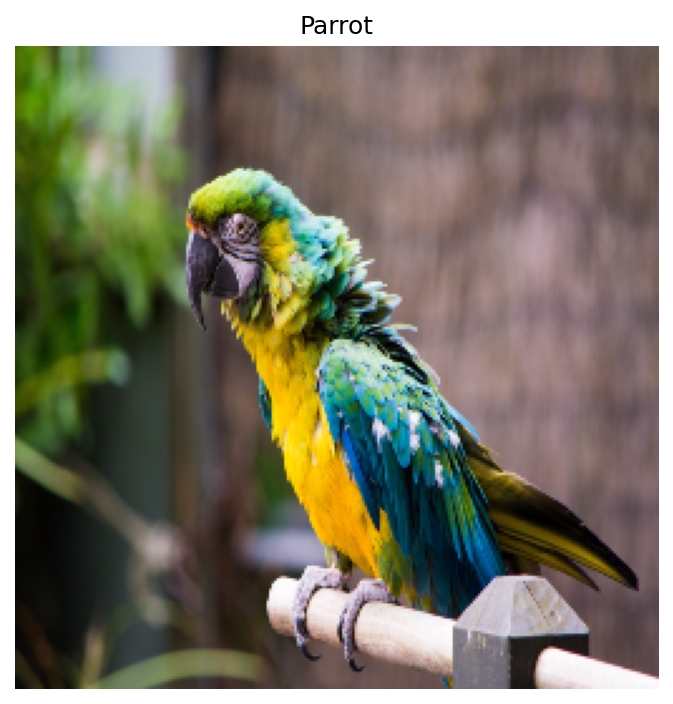

In [ ]:
parrot_png = resize_image(read_image('/content/drive/My Drive/ELEC546/HW3/parrot.png', grayscale=False), (256, 256))
show_image(parrot_png, title="Parrot")

Initial image shape: (678, 1020, 3)


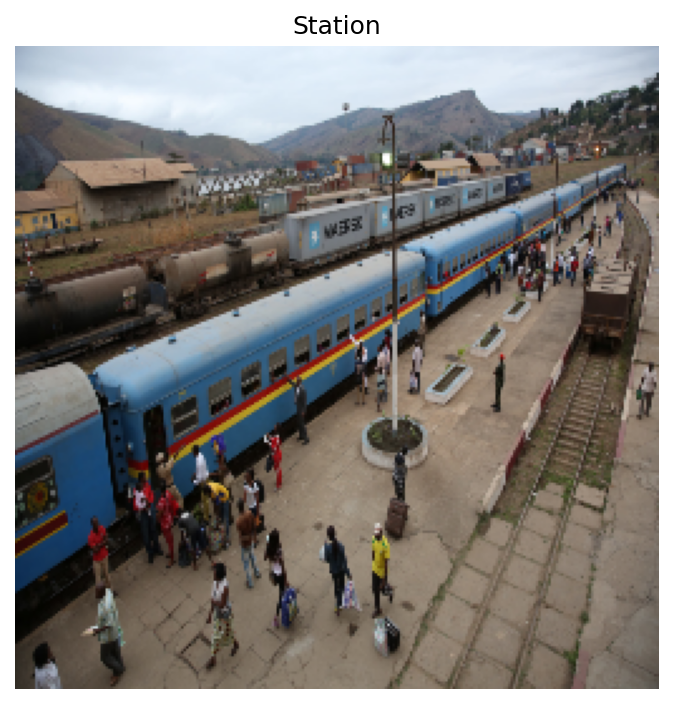

In [ ]:
station_png = resize_image(read_image('/content/drive/My Drive/ELEC546/HW3/station.png', grayscale=False), (256, 256))
show_image(station_png, title="Station")

In [ ]:
from numpy.linalg import svd


def pca_svd(X, k=None):
    """ Perform PCA using SVD and return the top k components."""

    ## Please write your own code to perform PCA.
    ## You may use numpy.linalg.eigh, or numpy.linalg.svd to obtain eigenvectors.

    X = X.astype(np.float32)
    # standardize first?? at least mean subtract
    # (X - mean(X)) / std(X)
    mean_X = np.mean(X, axis=0).astype(np.float32)
    X_ms = X - mean_X

    # Get eigenvectors V of C = X_0^T X_0
    # To represent X with K dimensions: Z_k = X V_k
    # To reconstruct: X = Z_k V_k^T + mean_x
    U, S, Vt = svd(X_ms, full_matrices=False)
    explained_variance = (S**2) / np.sum(S**2)

    # Select k driving components
    if k is not None:
      Vt = Vt[:k, :]

    Vt = Vt.astype(np.float32)
    return Vt, mean_X, explained_variance

def visualize_components(Vt, patch_size=16, n_comps_to_plot=36, num_channels=3):
    # Infer the correct patch size from Vt.shape[1]
    num_features = Vt.shape[1]
    patch_size = int(np.sqrt(num_features // num_channels))
    # Check if the patch size is valid
    if patch_size * patch_size * num_channels != num_features:
        raise ValueError(f"Patch size inference failed. Expected {num_features} to be 16x16x{num_channels} or similar.")

    # Create a 6x6 grid of the first 36 principal components
    fig, axes = plt.subplots(6, 6, figsize=(10, 10))
    for i, ax in enumerate(axes.ravel()):
        if i >= n_comps_to_plot:
            break
        # Reshape correctly and convert to grayscale (if necessary)
        patch = Vt[i].reshape((patch_size, patch_size, num_channels))
        ax.imshow(min_max_normalize(patch))  #, cmap='gray'
        ax.axis('off')
    plt.show()


def plot_variance_explained(explained_variance):
    plt.figure(figsize=(6, 3))
    plt.plot(np.cumsum(explained_variance) * 100, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Percent Variance Explained')
    plt.title('Explained Variance by Principal Components')
    # Get current axis and remove top/right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


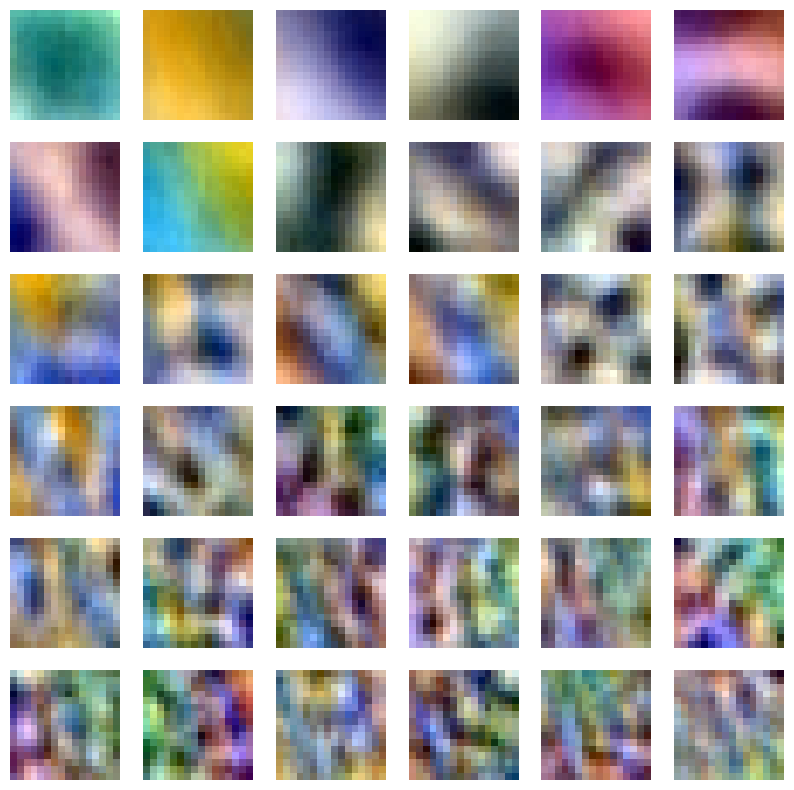

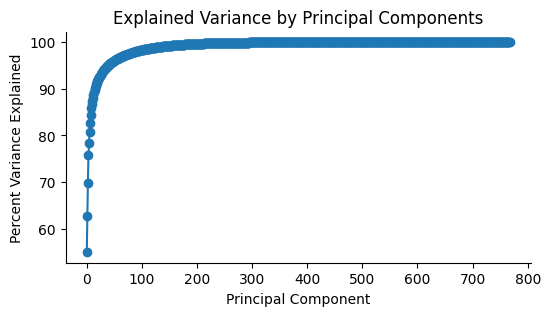

In [ ]:
### Your code starts here ###

# Get patches from image
parrot_patches = get_patches(parrot_png, patch_size=16, n_patches=1000, overlap=True)

# Implement PCA on the patches
X_parrot = parrot_patches.reshape(parrot_patches.shape[0], -1)  # Flatten patches
Vt_parrot, mean_X_parrot, exvar_parrot = pca_svd(X_parrot)

# Display the first 36 principal components
## Display the first 36 principal components as 16 x 16 images, arranged in a 6 x 6 grid
## (Note: remember to sort your eigenvalues and eigenvectors by decreasing eigenvalue magnitude!).
## Also report the % of variance captured by all principal components (not just the first 36) in a plot,
## x-axis being the component number, and y-axis being the % of variance explained by that component.

visualize_components(Vt_parrot[:36], patch_size=16)

plot_variance_explained(exvar_parrot)

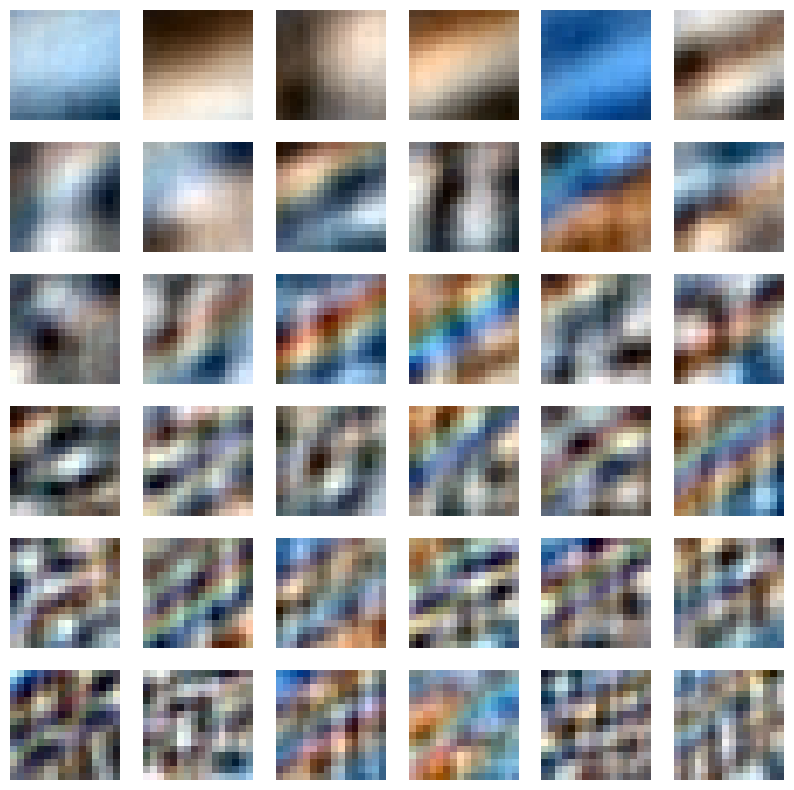

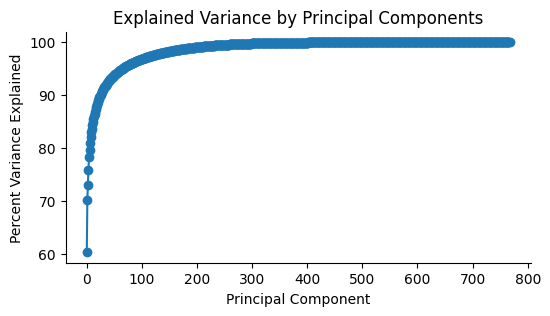

In [ ]:
# Get patches from image
station_patches = get_patches(station_png, patch_size=16, n_patches=1000, overlap=True)

# Implement PCA on the patches
X_station = station_patches.reshape(station_patches.shape[0], -1)  # Flatten patches
Vt_station, mean_X_station, exvar_station = pca_svd(X_station)

# Display the first 36 principal components
## Display the first 36 principal components as 16 x 16 images, arranged in a 6 x 6 grid
## (Note: remember to sort your eigenvalues and eigenvectors by decreasing eigenvalue magnitude!).
## Also report the % of variance captured by all principal components (not just the first 36) in a plot,
## x-axis being the component number, and y-axis being the % of variance explained by that component.

visualize_components(Vt_station[:36], patch_size=16)

plot_variance_explained(exvar_station)

### 4.2 Compress the image

In [ ]:
def reconstruct(img: np.ndarray, k: int, patch_size=16) -> np.ndarray:
    img = img.astype(np.float32)

    h, w, c = img.shape
    ## Assuming square patches and no overlap:
    num_patches = h * w // (patch_size * patch_size)  # It will actually return this no matter what size I pass in
    #print(f"num_patches: {num_patches}")

    # Extract patches
    patches = get_patches(img, patch_size=patch_size, n_patches=num_patches, overlap=False)
    #print(f"patches.shape: {patches.shape}")
    X = patches.reshape(num_patches, -1)  # Flatten patches

    # Create an empty image to store the reconstructed patches later
    reconstructed_image = np.zeros((h, w, c), dtype=np.float32)  # Shape (h, w, c)

    # Perform PCA reconstruction on each patch
    Vt, mean_X, explained_variance = pca_svd(X)
    #print(f"PCA Vt shape: {Vt.shape}")
    #print(f"k-PCA Vt[:k, :] shape: {Vt[:k, :].shape}")
    Z_k = X @ Vt[:k, :].T  # Project patches to lower dimension
    X_reconstructed = min_max_normalize(Z_k @ Vt[:k, :] + mean_X)  # Reconstruct and normalize
    #print(f"Patch shape before PCA, dataype: {X.shape, X.dtype}")
    #print(f"Shape after PCA compression, dataype: {Z_k.shape, X.dtype}")
    #print(f"Shape after reconstruction, dataype: {X_reconstructed.shape, X.dtype}")

    # Overlay reshaped, reconstructed patches in the output image
    idx = 0
    for i in range(patch_size):
        for j in range(patch_size):
            y_start, y_end = i*patch_size, (i + 1)*patch_size
            x_start, x_end = j*patch_size, (j + 1)*patch_size
            #print(f"i, j, ys, ye, xs, xe: {i, j, y_start, y_end, x_start, x_end}")
            reconstructed_patch = X_reconstructed[idx].reshape(patch_size, patch_size, c)
            #print(f"min, max reconstructed_patch: {min(reconstructed_patch.flatten()), max(reconstructed_patch.flatten())}")
            # ^ This is working: nonzero, all floats 0-1.0
            reconstructed_image[y_start:y_end, x_start:x_end, :] = reconstructed_patch
            idx += 1

    return reconstructed_image

In [ ]:
### Your code starts here ###

# Image reconstruction
## Show image reconstruction results using 1, 3, 10, 50, and 100 principal components.

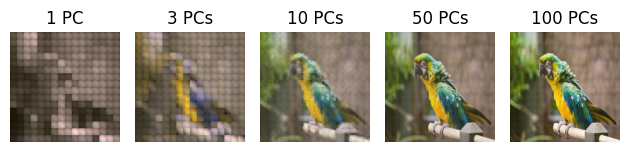

In [ ]:

X_rec1 = reconstruct(parrot_png, 1)
X_rec3 = reconstruct(parrot_png, 3)
X_rec10 = reconstruct(parrot_png, 10)
X_rec50 = reconstruct(parrot_png, 50)
X_rec100 = reconstruct(parrot_png, 100)

show_image_subplot([X_rec1, X_rec3, X_rec10, X_rec50, X_rec100], 1,5, titles=["1 PC", "3 PCs", "10 PCs", "50 PCs", "100 PCs"],dpi=100)


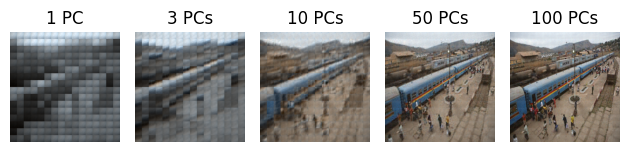

In [ ]:

X_rec1 = reconstruct(station_png, 1)
X_rec3 = reconstruct(station_png, 3)
X_rec10 = reconstruct(station_png, 10)
X_rec50 = reconstruct(station_png, 50)
X_rec100 = reconstruct(station_png, 100)

show_image_subplot([X_rec1, X_rec3, X_rec10, X_rec50, X_rec100], 1,5, titles=["1 PC", "3 PCs", "10 PCs", "50 PCs", "100 PCs"],dpi=100)
